# Bernoulli HMM Example Notebook

Modified from https://github.com/lindermanlab/ssm-jax-refactor/blob/main/notebooks/bernoulli-hmm-example.ipynb

Changes: It uses pyprobml's ssm-jax library, and finds the permutation between inferrred and true latent state labels in a different way.


In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [2]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/ssm-jax.git
    import ssm_jax
ssm_jax.__file__

'/Users/scott/Projects/ssm-jax/ssm_jax/__init__.py'

In [3]:
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

#### Imports and Plotting Functions 

In [4]:
import jax.random as jr
import jax.numpy as jnp
from jax import vmap

import tensorflow_probability.substrates.jax.distributions as tfd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# from scipy.optimize import linear_sum_assignment

from ssm_jax.hmm.models import BernoulliHMM
from ssm_jax.hmm.learning import hmm_fit_em

In [5]:
def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    Reference:
    https://github.com/lindermanlab/ssm/blob/646e1889ec9a7efb37d4153f7034c258745c83a5/ssm/plots.py#L20
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = jnp.linspace(0, 1, ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b, c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1.0, 1.0))

    cdict = {"red": tuple(reds), "green": tuple(greens), "blue": tuple(blues), "alpha": tuple(alphas)}

    cmap = LinearSegmentedColormap("grad_colormap", cdict, nsteps)
    return cmap

In [6]:
def find_permutation(z1, z2):
    K1 = z1.max() + 1
    K2 = z2.max() + 1

    perm = []
    for k1 in range(K1):
        indices = jnp.where(z1 == k1)[0]
        counts = jnp.bincount(z2[indices])
        perm.append(jnp.argmax(counts))

    return jnp.array(perm)

In [7]:
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue", "red", "amber", "faded green", "dusty purple", "orange"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def compare_transition_matrix(true_matrix, test_matrix):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (10, 5)
    if is_latexify_enabled():
        figsize = None
    latexify(width_scale_factor=1, fig_height=1.5)
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes(
        [
            axs[1].get_position().x1 + 0.07,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().y1 - axs[1].get_position().y0,
        ]
    )
    plt.colorbar(out, cax=cax)
    plt.show()


def plot_posterior_states(Ez, states, perm):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (25, 5)
    if is_latexify_enabled():
        figsize = None
    plt.figure(figsize=figsize)
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State", linewidth=1)
    plt.plot(Ez.T[perm].argmax(axis=0), "--", label="Predicted State", linewidth=1)
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Predicted vs. Ground Truth Latent State")

# Bernoulli HMM

### Let's create a true model

In [8]:
num_states = 5
num_channels = 10

initial_probabilities = jnp.ones((num_states,)) / (num_states * 1.0)
transition_matrix = 0.90 * jnp.eye(num_states) + 0.10 * jnp.ones((num_states, num_states)) / num_states
probs_prior = tfd.Beta(1, 1)
emission_probabilities = probs_prior.sample(seed=jr.PRNGKey(0), sample_shape=(num_states, num_channels))

true_hmm = BernoulliHMM(initial_probabilities, transition_matrix, emission_probabilities)

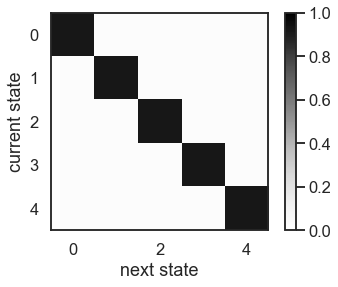

In [9]:
plot_transition_matrix(true_hmm.transition_matrix.value)

In [10]:
print("Emission probabilities (num states x num emission_dims (aka channels)):")
print(true_hmm.emission_probs.value)

Emission probabilities (num states x num emission_dims (aka channels)):
[[0.5101075  0.37463653 0.15845723 0.92877907 0.915876   0.2781816
  0.07606837 0.67227226 0.02824288 0.8792381 ]
 [0.60166305 0.17131579 0.8953847  0.16232777 0.21001732 0.3545916
  0.37099373 0.65532225 0.5685262  0.5294375 ]
 [0.86292917 0.07698138 0.21009283 0.48858947 0.91662025 0.9897732
  0.7091185  0.19263755 0.57043606 0.5730329 ]
 [0.977979   0.7871507  0.49274066 0.9426948  0.4235999  0.36467838
  0.07442135 0.20010759 0.11953039 0.34888312]
 [0.59595954 0.65374476 0.6496834  0.7097438  0.03907026 0.29472747
  0.20753238 0.11125415 0.6862083  0.60004115]]


### From the true model, we can sample synthetic data

In [11]:
rng = jr.PRNGKey(0)
num_timesteps = 500

states, data = true_hmm.sample(rng, num_timesteps)

### Let's view the synthetic data

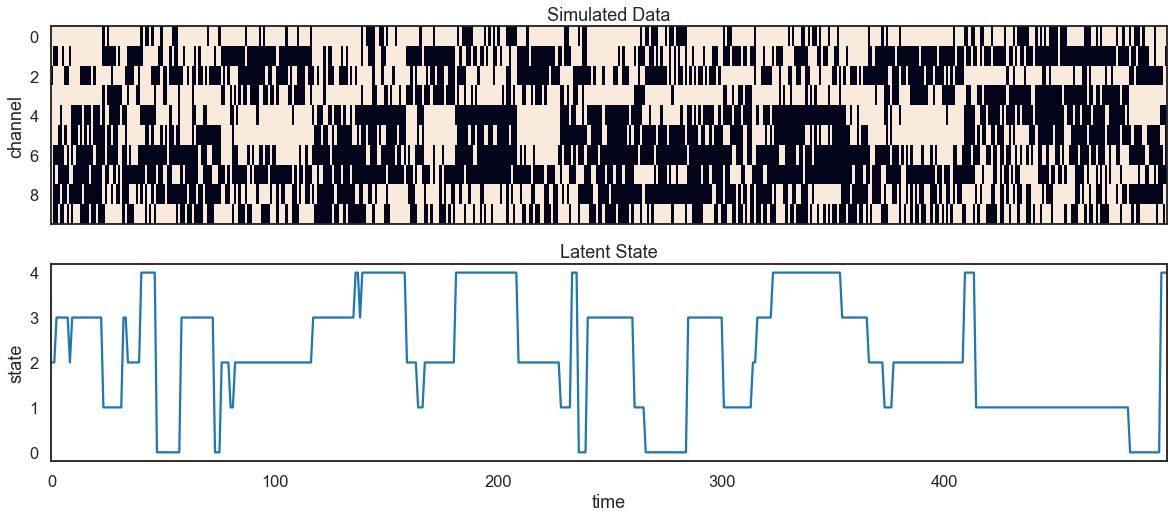

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("channel")
axs[0].set_title("Simulated Data")
axs[1].plot(states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


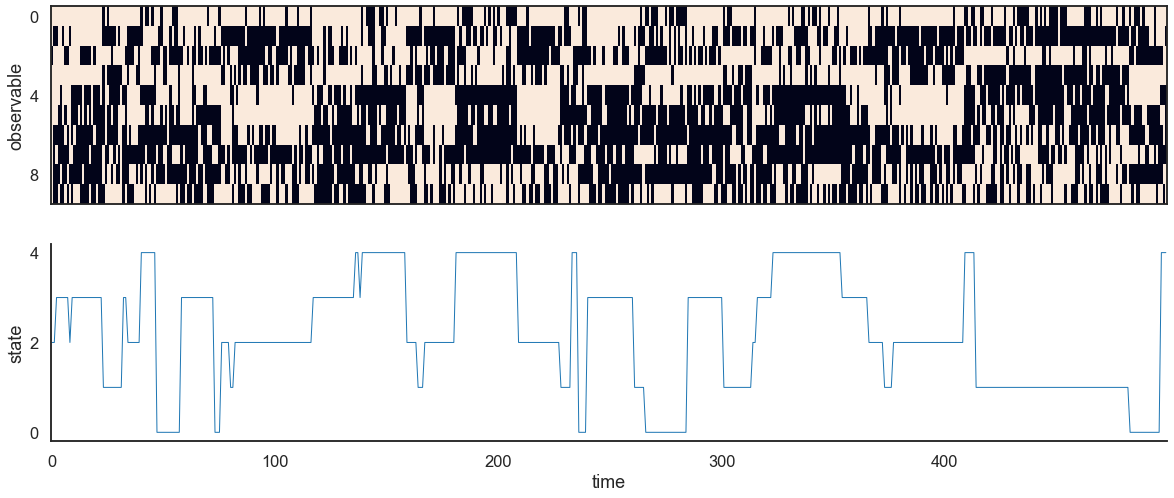

In [13]:
latexify(width_scale_factor=1, fig_height=2)
figsize = (20, 8)
if is_latexify_enabled():
    figsize = None
fig, axs = plt.subplots(2, 1, sharex=True, figsize=figsize)
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("observable")
axs[0].set_yticks([0, 4, 8])
axs[1].plot(states, linewidth=1)
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
axs[1].set_yticks([0, 2, 4])
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
if is_latexify_enabled():
    plt.subplots_adjust(hspace=4)
savefig("bernoulli-hmm-data")
plt.show()

## Fit HMM using exact EM update

In [14]:
emission_probabilities = probs_prior.sample(seed=jr.PRNGKey(32), sample_shape=(num_states, num_channels))
test_hmm = BernoulliHMM(initial_probabilities, transition_matrix, emission_probabilities)

In [15]:
batch_size = 1
num_iters = 20
test_hmm, lps = hmm_fit_em(
    test_hmm, data.reshape((batch_size, num_timesteps, num_channels)), num_iters=num_iters
)

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'log likelihood')

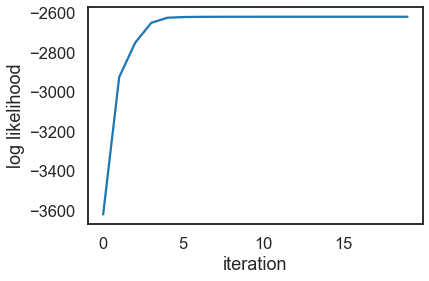

In [16]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

In [17]:
test_hmm.transition_matrix

Parameter(value=[[9.43168938e-01 2.43659578e-02 1.16927745e-02 1.17545547e-02
  9.01776366e-03]
 [2.49598641e-02 9.20618892e-01 8.33891647e-07 1.70275401e-02
  3.73928286e-02]
 [3.55935754e-06 1.94390155e-02 9.03613389e-01 7.69419745e-02
  2.06907112e-06]
 [2.44830307e-02 1.70378052e-02 9.36318003e-03 9.21879351e-01
  2.72366535e-02]
 [1.50405469e-06 3.98384631e-02 2.65816264e-02 9.25734919e-03
  9.24321115e-01]], is_frozen=False, bijector=tfp.bijectors.Invert("invert_softmax_centered", batch_shape=[], min_event_ndims=1, bijector=SoftmaxCentered))

/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


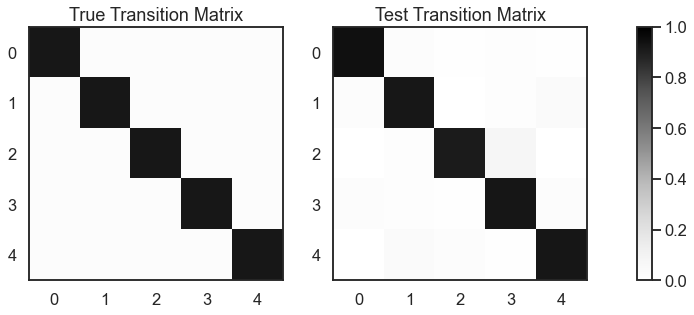

In [18]:
# Compare the transition matrices
compare_transition_matrix(true_hmm.transition_matrix.value, test_hmm.transition_matrix.value)

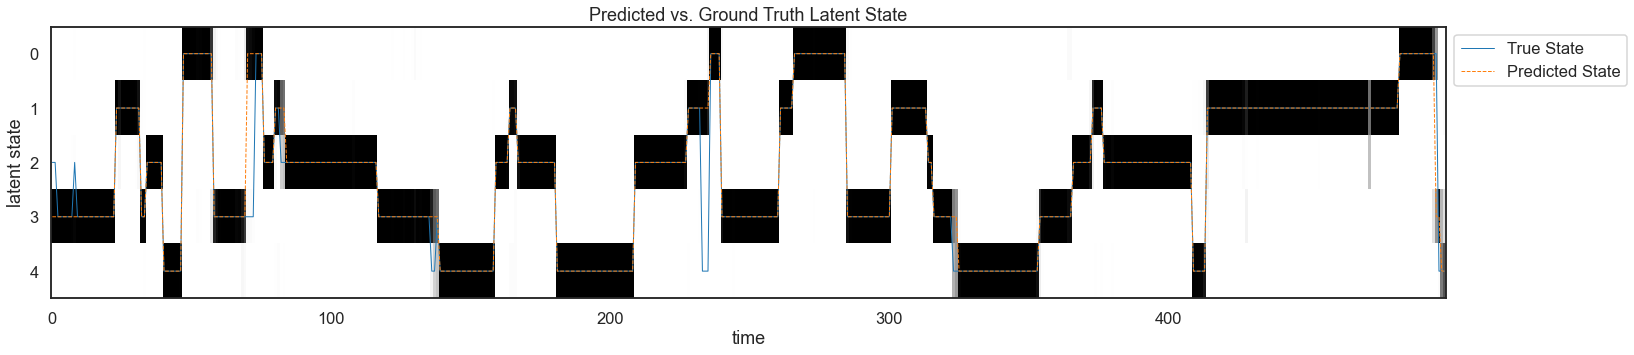

In [19]:
# Posterior distribution
posterior = test_hmm.smoother(data)
Ez = posterior.smoothed_probs
perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
plot_posterior_states(Ez, states, perm)

# Fit Bernoulli Over Multiple Trials

In [20]:
rng = jr.PRNGKey(0)
num_trials = 5
keys = jr.split(rng, num_trials)
num_timesteps = 500

all_states, all_data = vmap(true_hmm.sample, in_axes=(0, None))(keys, num_timesteps)

In [21]:
# Now we have a batch dimension of size `num_trials`
print(all_states.shape)
print(all_data.shape)

(5, 500)
(5, 500, 10)


In [22]:
num_iters = 100
test_hmm, lps = hmm_fit_em(test_hmm, all_data, num_iters=100)

  0%|          | 0/100 [00:00<?, ?it/s]

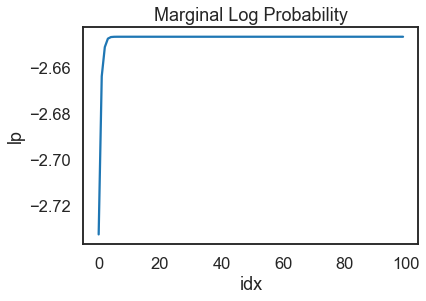

In [23]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(jnp.array(lps) / data.size)

/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


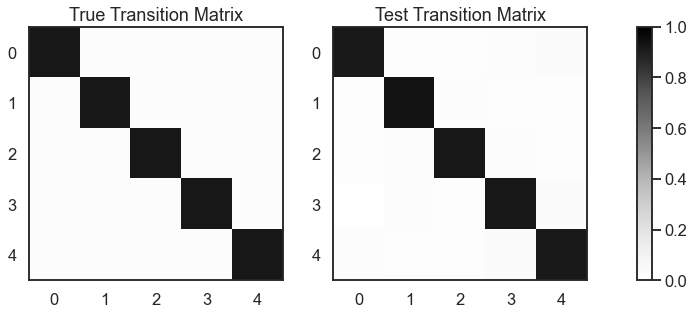

In [24]:
compare_transition_matrix(true_hmm.transition_matrix.value, test_hmm.transition_matrix.value)

===== Trial: 0 =====
===== Trial: 1 =====
===== Trial: 2 =====


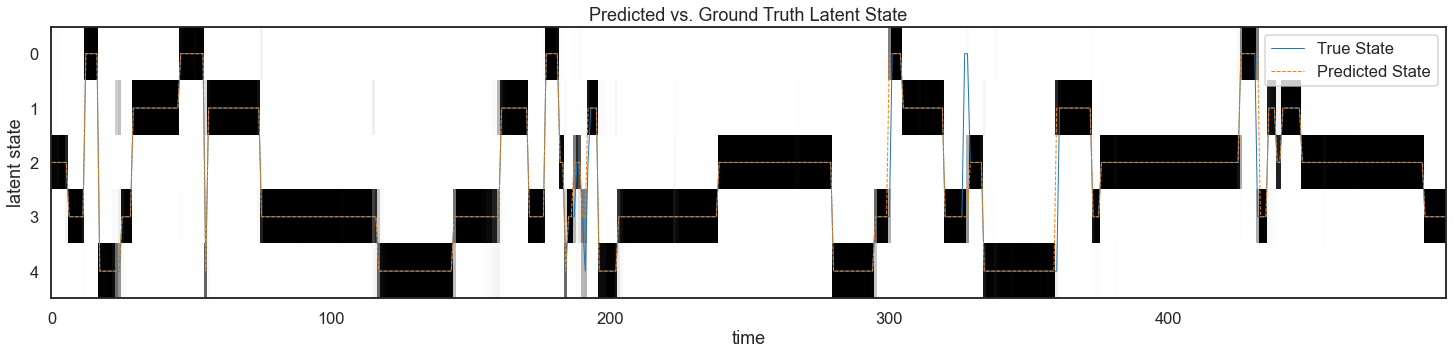

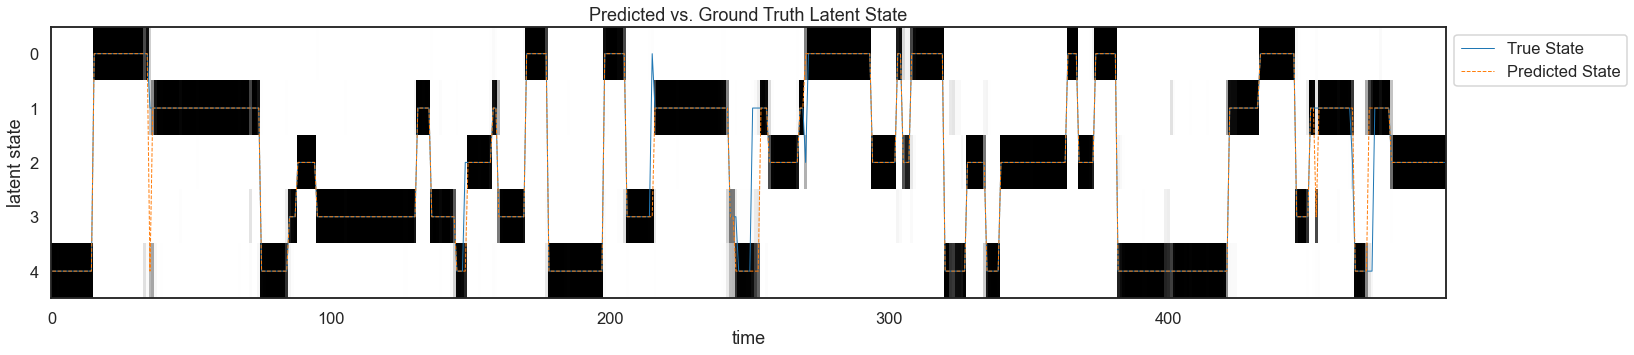

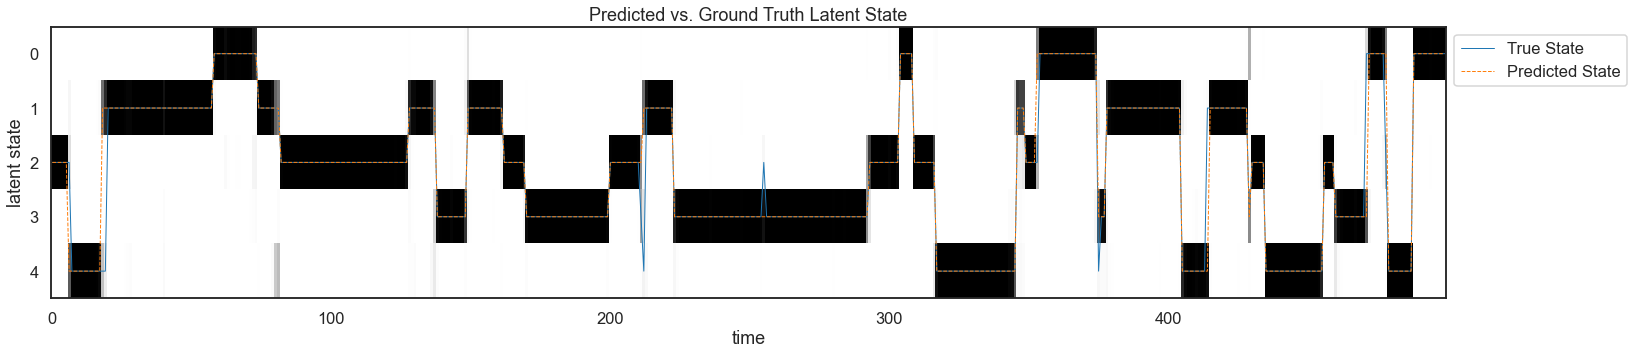

In [25]:
# For the first few trials, let's see how good our predicted states are
for trial_idx in range(3):
    print("=" * 5, f"Trial: {trial_idx}", "=" * 5)
    posterior = test_hmm.smoother(all_data[trial_idx])
    Ez = posterior.smoothed_probs
    states = all_states[trial_idx]
    perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)